In [1]:
import matplotlib.pyplot as plt

In [2]:
import torch
import os
import logging
import scanpy as sc
import random

/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.__version__

'1.9.3'

In [4]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

torch==1.13.1
logging==0.5.1.2
scanpy==1.9.3


In [5]:
logger = logging.getLogger("scvi.inference.autotune")
logger.setLevel(logging.WARNING)
torch.cuda.get_device_name(0)

AssertionError: Torch not compiled with CUDA enabled

In [6]:
import numpy as np

In [7]:
import scvi as scvi

Global seed set to 0
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/flax/struct.py:132: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(data_clz, keypaths)


In [8]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    scvi.settings.seed = seed # scvi-tools seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
seed=42
set_seed(seed)

Global seed set to 42


In [ ]:
adata = sc.read_h5ad(
    "../output/H5AD/mergedH.h5ad")


In [ ]:
adata

In [ ]:
adata.obs["orig.ident"].unique()

In [ ]:
target_conditions = ["Sample_C27_DAPI_3", "Sample_Unsorted_WA09_5", 'Sample_32', 'Sample_33', 'Sample_34', 'Sample_WA09_Shiv', "Sample_unsorted",'Sample_CD-140', 'Sample_C27_CD140_3', "Sample_CD140_WA09_5", "Sample_C27_Shi", "GOL-2512A5", "GOL2976A5"]

In [ ]:
adata = adata[adata.obs['orig.ident'].isin(target_conditions)].copy()

In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [ ]:
adata.obs["concat"] = adata.obs["line"] + adata.obs["chemistry"]

In [ ]:
adata.obs["concat"].unique()

In [ ]:
### Currently used 3000
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=True,
    layer="counts",
    flavor="seurat_v3",
    batch_key="concat",
    span = .5, 
)

In [ ]:
scvi.data.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["chemistry", "line", "orig.ident"],
    continuous_covariate_keys=["percent.mt", "nCount_RNA", "nFeature_RNA"]
)

In [ ]:
model = scvi.model.SCVI(adata)

In [ ]:
model

In [ ]:
model.train(use_gpu=True)

In [ ]:
model

In [ ]:
model.save("../output/scVI/Invitro_Invivo_Model")


In [ ]:
adata.obsm["X_scVI"] = model.get_latent_representation()

In [ ]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(
    library_size=10e4
)

In [ ]:
adata.write("../H5AD/Invitro_Invivo.h5ad")

In [ ]:
adata = sc.read_h5ad(
    "../H5AD/Invitro_Invivo.h5ad")

In [12]:
# 100.  Seed = 0
sc.pp.neighbors(adata, use_rep="X_scVI", n_neighbors = 250, random_state=seed)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [13]:
# min_dist = .6
sc.tl.umap(adata, min_dist = .48, random_state=seed)

/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


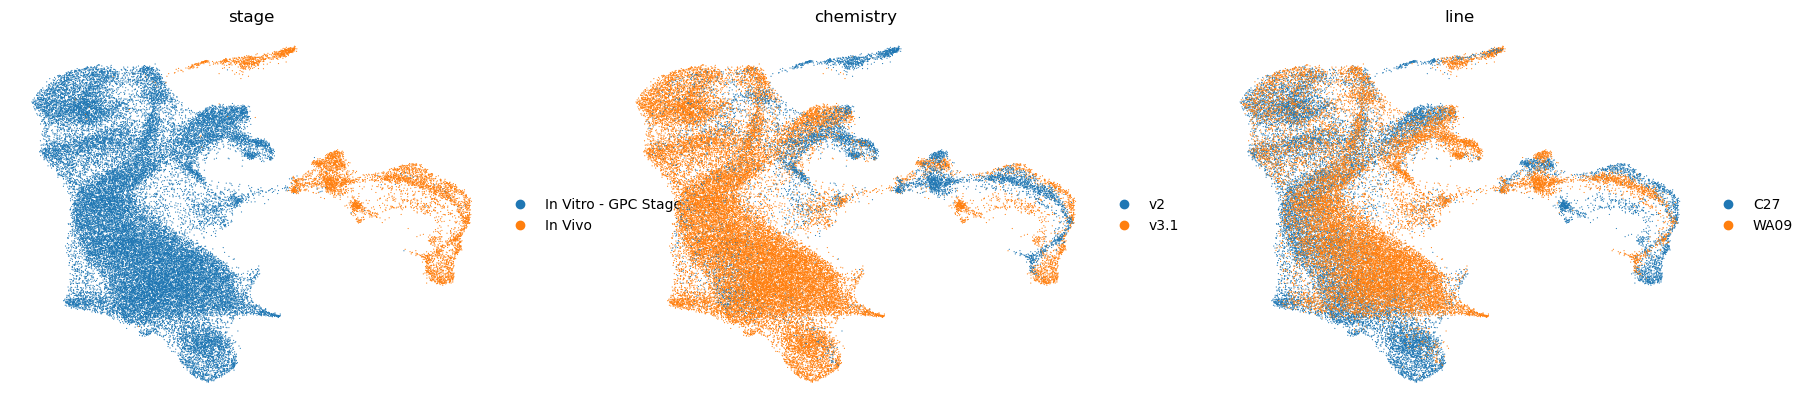

In [14]:
#1
sc.pl.umap(
    adata,
    color=["stage", "chemistry", "line"],
    frameon=False
)

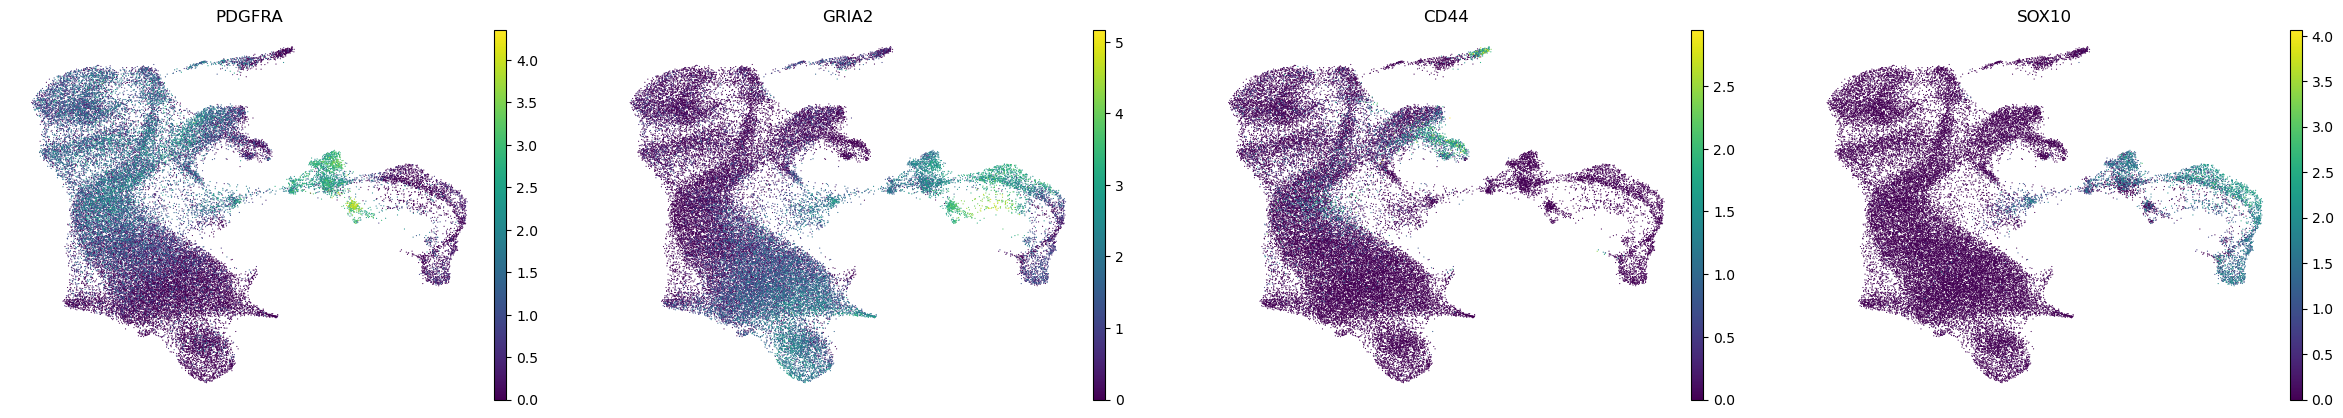

In [15]:
#1
sc.pl.umap(
    adata,
    color=["PDGFRA", "GRIA2", "CD44", "SOX10"],
    frameon=False
)

In [19]:
# .38
sc.tl.leiden(adata, key_added="leiden_scVI", resolution= .38)



/opt/homebrew/Caskroom/mambaforge/base/envs/scvi-env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


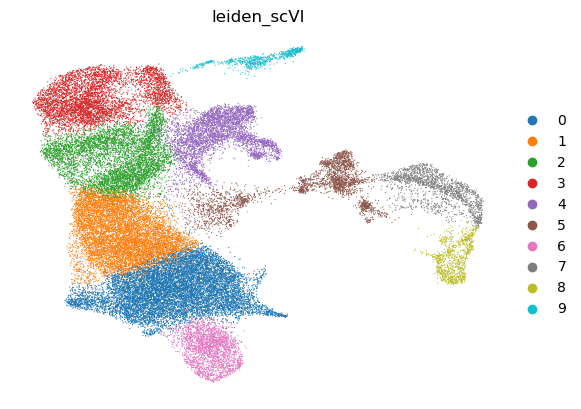

In [20]:
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    frameon=False
)

In [ ]:
sc.pl.violin(adata, keys = ["GRIA2", "MKI67", "PDGFRA", "STMN2"], groupby="leiden_scVI", rotation = 90)

In [ ]:
sc.pl.umap(
    adata[adata.obs["stage"] == "In Vitro - GPC Stage"],
    color = ["leiden_scVI"],
    
)

In [ ]:
sc.pl.umap(
    adata[adata.obs["stage"] == "In Vitro - GPC Stage"],
    color = ["leiden_scVI"],
    
)

In [ ]:
adata.write("../output/scVI/Invitro_Invivo_42.h5ad")

In [ ]:
umapEmbeddings = adata.obsm["X_umap"]

In [ ]:
np.savetxt("../outpu/scVI/Invitro_Invivo_umapEmbeddings.csv", umapEmbeddings, delimiter=",")

In [ ]:
leiden_clusters = adata.obs["leiden_scVI"]

In [ ]:
type(leiden_clusters)

In [ ]:
adata.obs["leiden_scVI"].to_csv('../output/scVI/Invitro_Invivo_leiden.csv')


In [18]:
adata.layers

Layers with keys: counts, scvi_normalized

In [21]:
adata.write("../output/scVI/invitroInvivoUpdated.h5ad")